<H1> Use of Deep Learning to Predict the Number of Bikes in Montreal </H1>
<H4> By Samuel Renaud and Bowen Xu </H4>





**Run the code cell below** to import the required packages.

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from ray import tune #for hyper parameter tuning
torch.manual_seed(0); # for reproducibility of results

<H2> The first step is to pre-process the bicycle data </H2>
<H4> *Note the year 2019 has different formatting and is done in the following cell </H4>

In [2]:
#this extracts the bike counts for a given year but other years need to be specified for years 2010-2018
bike_count_2009 = pd.read_csv('bike_count/comptagevelo2009.csv')
bike_count_2009 = bike_count_2009.fillna(0)
bike_count_2009 = bike_count_2009[['Berri1','Maisonneuve_2','Maisonneuve_1']].astype('int64')

#This identifies the fields to be extracted from the daily weather data
fields = ['Max Temp (°C)', 
          'Min Temp (°C)',
         'Mean Temp (°C)',
         'Total Precip (mm)',
          'Snow on Grnd (cm)',
         'Year',
         'Month',
         'Day']

#This imports the corresponding daily weather data and fill the NAN cells with 0
weather_2009 = pd.read_csv('weather_daily/en_climate_daily_QC_702S006_2009_P1D.csv', usecols=fields)
weather_2009 = weather_2009.fillna(0)

#This identifies the fields to be extracted from the hourly weather data
fields = ['Dew Point Temp (°C)', 
          'Rel Hum (%)',
          'Wind Dir (10s deg)',
          'Wind Spd (km/h)',
         'Wind Chill']

weather_hourly_2009 = pd.read_csv('weather_hourly/en_climate_hourly_QC_702S006_01-2009_P1H.csv', usecols=fields)

# This for loop goes through all the hourly datasets for a given year (here is 2009) and concatenates the samples together
for i in range(11):
    n = i+2
    name = open("weather_hourly/en_climate_hourly_QC_702S006_%.2d-2009_P1H.csv" % n)
    weather_hourly_2009_temp = pd.read_csv(name)
    weather_hourly_2009_temp
    weather_hourly_2009 = pd.concat([weather_hourly_2009, weather_hourly_2009_temp], axis=0, join="inner")

# This converts the hourly datasets (here for 2009) to a daily basis by averaging
weather_hourly_2009 = weather_hourly_2009.fillna(0)
weather_hourly_2009 = weather_hourly_2009.groupby(np.arange(len(weather_hourly_2009))//24).mean()
weather_hourly_2009.reindex()

# This merges the bike counts and weather data together
totalData_2009 = pd.concat([weather_2009,weather_hourly_2009,bike_count_2009], axis=1, join="inner")
totalData_2009.to_csv('totalData_2009.csv',index=False)
totalData_2009.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                365 non-null    int64  
 1   Month               365 non-null    int64  
 2   Day                 365 non-null    int64  
 3   Max Temp (°C)       365 non-null    float64
 4   Min Temp (°C)       365 non-null    float64
 5   Mean Temp (°C)      365 non-null    float64
 6   Total Precip (mm)   365 non-null    float64
 7   Snow on Grnd (cm)   365 non-null    float64
 8   Rel Hum (%)         365 non-null    float64
 9   Wind Dir (10s deg)  365 non-null    float64
 10  Wind Spd (km/h)     365 non-null    float64
 11  Wind Chill          365 non-null    float64
 12  Berri1              365 non-null    int64  
 13  Maisonneuve_2       365 non-null    int64  
 14  Maisonneuve_1       365 non-null    int64  
dtypes: float64(9), int64(6)
memory usage: 42.9 KB


In [3]:
# The organization of the dataframe of bike counts has been changed since 2019 (included)
# and the counting interval has been increased from an hour to 15 min since 2019 (included)
# So a special treatment must be brought to 2019

# The differences include renaming the attribute for the selected counters, removing the duplicated data on July and
# group the 15-min records into a daily basis by adding up

bike_count_2019 = pd.read_csv('bike_count/comptage_velo_2019.csv')
bike_count_2019 = bike_count_2019[['Date','compteur_100003032','compteur_100003039','compteur_100011783']]
bike_count_2019 = bike_count_2019.drop_duplicates(subset=['Date','compteur_100003032','compteur_100003039','compteur_100011783'])
bike_count_2019 = bike_count_2019.reindex()
bike_count_2019 = bike_count_2019.fillna(0)
bike_count_2019 = bike_count_2019.groupby(np.arange(len(bike_count_2019))//96).sum().round(decimals=0).astype('int64')
bike_count_2019.rename(columns={"compteur_100003032": "Berri1", "compteur_100003039": "Maisonneuve_2", "compteur_100011783": "Maisonneuve_3"})
bike_count_2019;

In [4]:
#This identifies the fields to be extracted from the daily weather data
fields = ['Max Temp (°C)', 
          'Min Temp (°C)',
         'Mean Temp (°C)',
         'Total Precip (mm)',
          'Snow on Grnd (cm)',
         'Year',
         'Month',
         'Day']

#This imports the corresponding daily weather data and fill the NAN cells with 0
weather_2019 = pd.read_csv('weather_daily/en_climate_daily_QC_702S006_2019_P1D.csv', usecols=fields)
weather_2019 = weather_2019.fillna(0)

#This identifies the fields to be extracted from the hourly weather data
fields = ['Dew Point Temp (°C)', 
          'Rel Hum (%)',
          'Wind Dir (10s deg)',
          'Wind Spd (km/h)',
         'Wind Chill']


weather_hourly_2019 = pd.read_csv('weather_hourly/en_climate_hourly_QC_702S006_01-2019_P1H.csv', usecols=fields)

# This for loop goes through all the hourly datasets for a given year (here is 2019) and concatenates the samples together
for i in range(11):
    n = i+2
    name = open("weather_hourly/en_climate_hourly_QC_702S006_%.2d-2019_P1H.csv" % n)
    weather_hourly_2019_temp = pd.read_csv(name)
    weather_hourly_2019_temp
    weather_hourly_2019 = pd.concat([weather_hourly_2019, weather_hourly_2019_temp], axis=0, join="inner")

# This converts the hourly datasets (here for 2019) to a daily basis by averaging
weather_hourly_2019 = weather_hourly_2019.fillna(0)
weather_hourly_2019 = weather_hourly_2019.groupby(np.arange(len(weather_hourly_2019))//24).mean()
weather_hourly_2019.reindex()

totalData_2019 = pd.concat([weather_2019,weather_hourly_2019,bike_count_2019], axis=1, join="inner")
totalData_2019.to_csv('totalData_2019.csv',index=False)
totalData_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                365 non-null    int64  
 1   Month               365 non-null    int64  
 2   Day                 365 non-null    int64  
 3   Max Temp (°C)       365 non-null    float64
 4   Min Temp (°C)       365 non-null    float64
 5   Mean Temp (°C)      365 non-null    float64
 6   Total Precip (mm)   365 non-null    float64
 7   Snow on Grnd (cm)   365 non-null    float64
 8   Rel Hum (%)         365 non-null    float64
 9   Wind Dir (10s deg)  365 non-null    float64
 10  Wind Spd (km/h)     365 non-null    float64
 11  Wind Chill          365 non-null    float64
 12  compteur_100003032  365 non-null    int64  
 13  compteur_100003039  365 non-null    int64  
 14  compteur_100011783  365 non-null    int64  
dtypes: float64(9), int64(6)
memory usage: 42.9 KB


<H2> With the bicycle & weather data pre-processed we can move on to data analysis </H2>
<H4> *Note all the years have been compiled and stored in the totalData csv file </H4>

In [5]:
# import the total datasets consisting of all the samples from 2009-2019 with selected attributes and targets
df = pd.read_csv('data\\totalData.csv')
df.head(3)

,Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Precip (mm),Snow on Grnd (cm),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Wind Chill,Berri1,Maisonneuve_2,Maisonneuve_1
0,2009.0,1.0,1.0,-14.7,-19.9,-17.3,0.0,0.0,-23.125000,59.916667,28.291667,17.375000,-25.875000,29.0,35.0,20.0
1,2009.0,1.0,2.0,-11.3,-16.2,-13.8,1.0,0.0,-17.029167,76.250000,7.083333,12.250000,-19.458333,19.0,22.0,3.0
2,2009.0,1.0,3.0,-8.1,-13.0,-10.6,0.0,0.0,-15.441667,67.958333,28.208333,22.541667,-18.708333,24.0,22.0,12.0


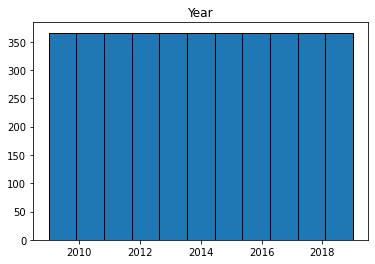

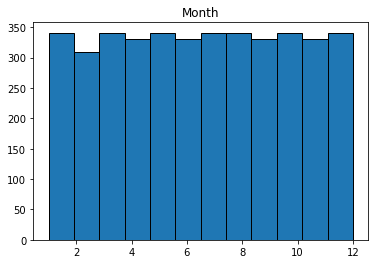

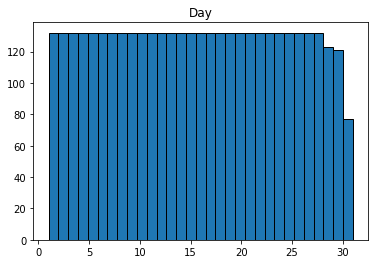

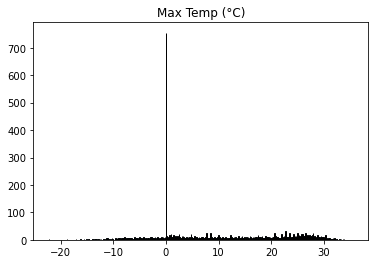

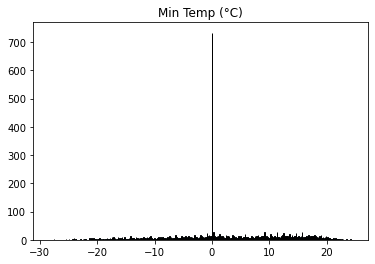

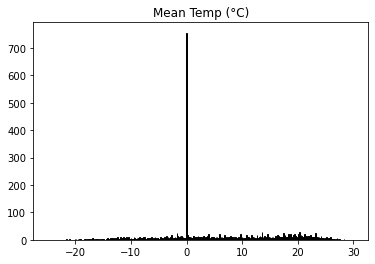

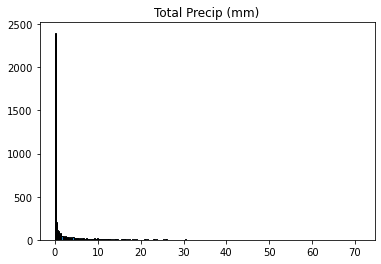

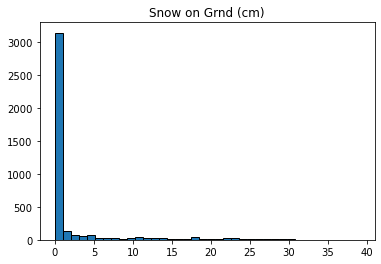

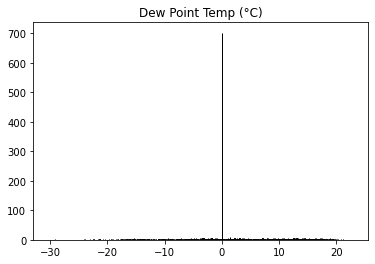

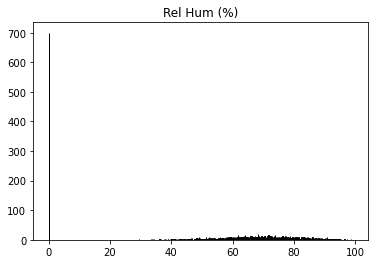

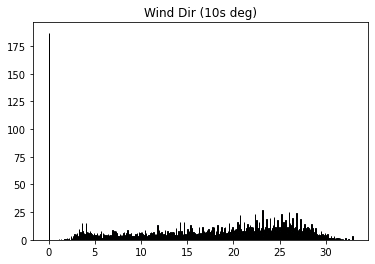

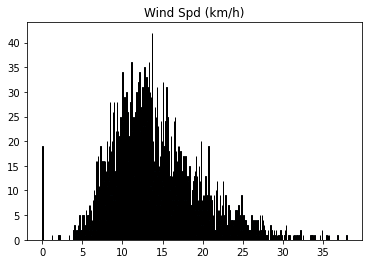

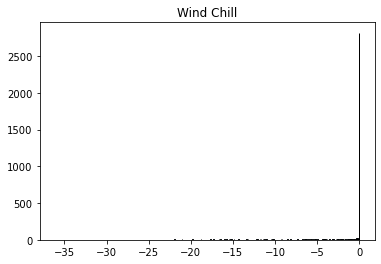

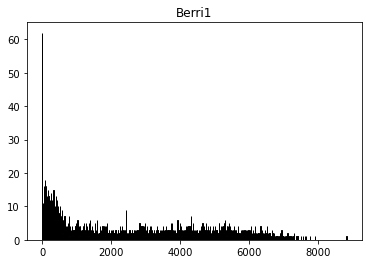

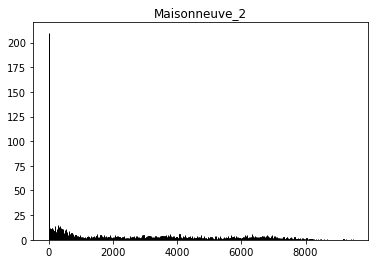

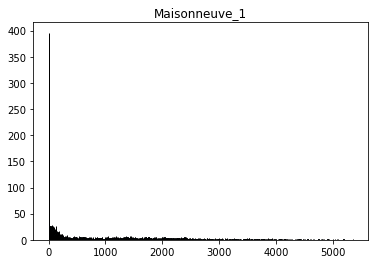

In [6]:
#make a histogram of all the features
for column in df.columns:
    plt.figure()
    plt.hist(df[column], bins=df[column].nunique(), edgecolor='k')
    plt.title(column)

Let's drop all the columns with zero bikes (note that although some days might really have 0 there is too much bias towards 0 due to the erroneous days)

In [7]:
df = df.drop(df[(df['Berri1']==0) | (df['Maisonneuve_2']==0) | (df['Maisonneuve_1']==0)].index)

Wind chill only appears when temperatures are below zero! This makes things complicated let's remove it for now
<br>
Let's also get rid of sparse columns like [Total Precip] and [Snow on Grnd (cm)] for now.

In [8]:
df = df.drop(columns=['Wind Chill','Total Precip (mm)','Snow on Grnd (cm)'])

Finally we drop the data sparse days where many things are missing simultaneously

In [9]:
df = df.drop(df[(df['Max Temp (°C)']==0) & (df['Min Temp (°C)']==0) & (df['Mean Temp (°C)']==0) & (df['Dew Point Temp (°C)']==0) & (df['Rel Hum (%)']==0)].index)

let's take another look at those histograms

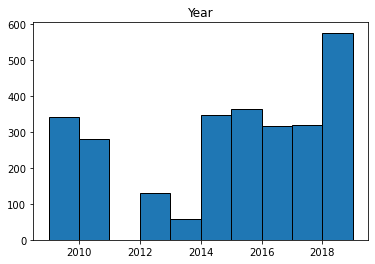

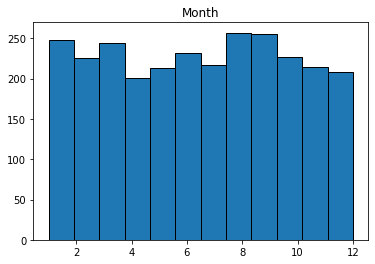

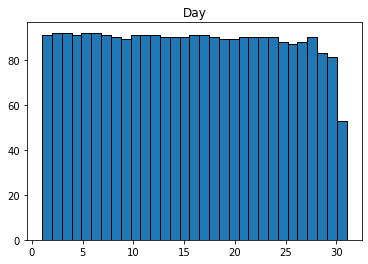

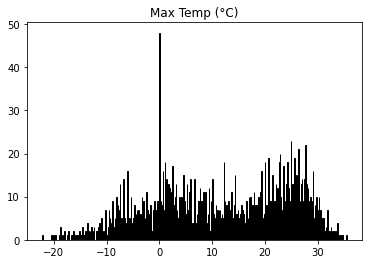

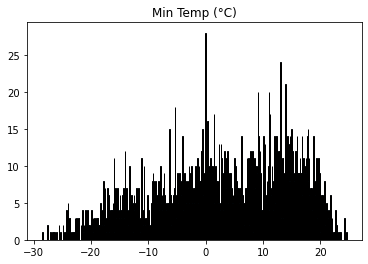

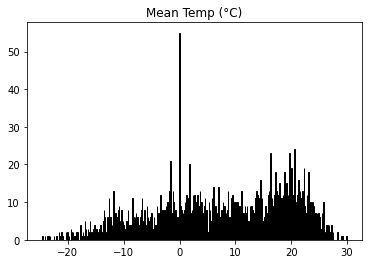

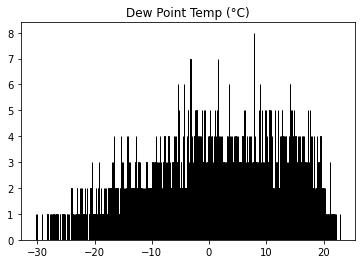

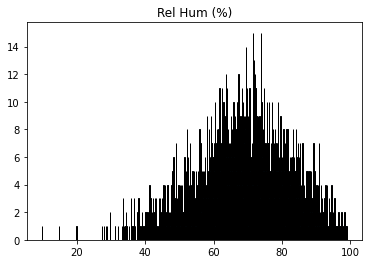

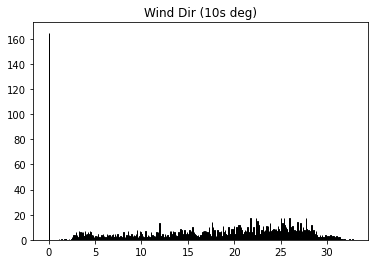

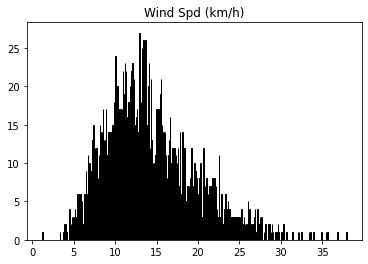

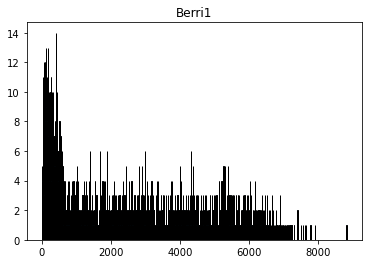

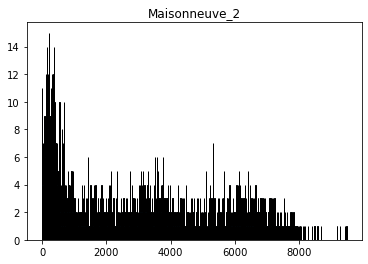

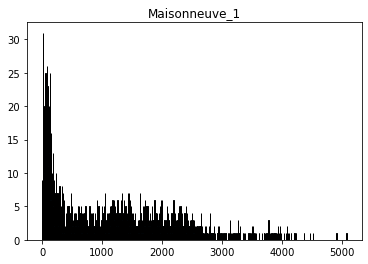

In [10]:
for column in df.columns:
    plt.figure()
    plt.hist(df[column], bins=df[column].nunique(), edgecolor='k')
    plt.title(column)

While there are still some spurious spikes most of the anomalies have been adressed.
We save the dataset for loading into the mode

In [11]:
df.to_csv('processed_data.csv',index=None)

<H2> KNN MODEL </H2>

Import the processed data

In [12]:
data = pd.read_csv('processed_data.csv')
data.head(3)

,Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Berri1,Maisonneuve_2,Maisonneuve_1
0,2009.0,1.0,1.0,-14.7,-19.9,-17.3,-23.125000,59.916667,28.291667,17.375000,29.0,35.0,20.0
1,2009.0,1.0,2.0,-11.3,-16.2,-13.8,-17.029167,76.250000,7.083333,12.250000,19.0,22.0,3.0
2,2009.0,1.0,3.0,-8.1,-13.0,-10.6,-15.441667,67.958333,28.208333,22.541667,24.0,22.0,12.0


Select the dataset to train on by typing into choices dictionnary: berri, maison2, maison1

In [13]:
choices = {'berri':"Berri1",'maison2':"Maisonneuve_2",'maison1':"Maisonneuve_1" }

selection = choices['maison2']  #<- select by typing into here

y = data[selection].to_numpy()

In [14]:
#create custom bin sizes based on Freedman–Diaconis rule see: https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule
q3, q1 = np.percentile(y,[75,25])
bin_width = int(2*(q3-q1)/np.cbrt(len(y)))
bins = np.arange(0,max(y)+bin_width,bin_width)

To_categorize = np.arange(0,len(bins)-1,1)

data = data.assign(Berri1=pd.cut(data['Berri1'], 
                               bins=bins, 
                               labels=To_categorize))
data = data.assign(Maisonneuve_2=pd.cut(data['Maisonneuve_2'], 
                               bins=bins, 
                               labels=To_categorize))
data = data.assign(Maisonneuve_1=pd.cut(data['Maisonneuve_1'], 
                               bins=bins, 
                               labels=To_categorize))
bike_data=data

In [15]:
columns_to_normalize = ['Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)', 'Dew Point Temp (°C)',
                         'Rel Hum (%)', 'Wind Dir (10s deg)', 'Wind Spd (km/h)']

std_scaler = StandardScaler()
features = bike_data[columns_to_normalize]
scaled_features = std_scaler.fit_transform(features)
scaled_features = pd.DataFrame(scaled_features, index=bike_data.index)
scaled_features.columns = columns_to_normalize
bike_data[columns_to_normalize] = scaled_features

In [16]:
X = bike_data.drop(labels=['Berri1', 'Maisonneuve_2', 'Maisonneuve_1'],axis=1)
y = bike_data[selection]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10) 

knn = KNeighborsClassifier(n_neighbors=80, weights='distance',p=1)
knn.fit(X_train,y_train)
pred_train = knn.predict(X_train)
pred_test = knn.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('training set accuracy', acc_train.round(3))
print('test set accuracy', acc_test.round(3))


training set accuracy 1.0
test set accuracy 0.32


<H2> ANN MODEL </H2>

Load the data and show the first 3 data points

In [18]:
data = pd.read_csv('processed_data.csv')
data.head(3)

,Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Berri1,Maisonneuve_2,Maisonneuve_1
0,2009.0,1.0,1.0,-14.7,-19.9,-17.3,-23.125000,59.916667,28.291667,17.375000,29.0,35.0,20.0
1,2009.0,1.0,2.0,-11.3,-16.2,-13.8,-17.029167,76.250000,7.083333,12.250000,19.0,22.0,3.0
2,2009.0,1.0,3.0,-8.1,-13.0,-10.6,-15.441667,67.958333,28.208333,22.541667,24.0,22.0,12.0


In [19]:
#drop the y's from the X data and drop the dates on the X
X = torch.Tensor(data.drop(columns=['Berri1','Maisonneuve_2','Maisonneuve_1']).to_numpy())
X = X[:, 3:]
#select which of the 3 stations to train on
y = torch.Tensor(data['Berri1'].to_numpy())

create bins and plot a histogram

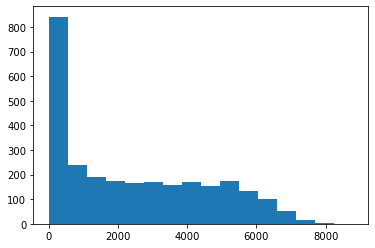

In [20]:
q3, q1 = np.percentile(y,[75,25])
bin_width = int(2*(q3-q1)/np.cbrt(len(y)))
bins = np.arange(0,max(y),bin_width)

plt.hist(y.squeeze().numpy(), bins=bins);

In [21]:
y_bin = np.digitize(y.unsqueeze(1), bins)
one_hot = OneHotEncoder()
y_hot = torch.Tensor((one_hot.fit_transform(y_bin)).toarray())

Let's Split the test, train and validation datasets, we also scramble the data here

In [22]:
X_train,X_test, y_train, y_test = train_test_split(X,y_hot, test_size=0.10)

X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size=0.14)

print("X:", X.shape, "y:", y.shape,
      "\nX_train:", X_train.shape, "y_train:", y_train.shape,
      "\nX_test:", X_test.shape, "y_test:", y_test.shape,
     "\nX_val:", X_val.shape, "y_val:", y_val.shape)

X: torch.Size([2743, 7]) y: torch.Size([2743]) 
X_train: torch.Size([2468, 7]) y_train: torch.Size([2468, 16]) 
X_test: torch.Size([236, 7]) y_test: torch.Size([236, 16]) 
X_val: torch.Size([39, 7]) y_val: torch.Size([39, 16])


In [23]:
class BikeModel(torch.nn.Module):
    '''
    BikeModel neural network classifier
    __init__ : initializes the model specifying network shapes
    forward: incorporates the layers into the forward pass
    '''
    def __init__(self, linear=10, drop=0.50, out_features=16):
        super(BikeModel, self).__init__()
        self.linear1 = torch.nn.Linear(in_features=7, out_features=linear)
        self.linear2 = torch.nn.Linear(in_features=linear,out_features=linear)
        self.linear3 = torch.nn.Linear(in_features=linear,out_features=out_features)
        self.drop1 = torch.nn.Dropout(p=drop)
        self.drop2 = torch.nn.Dropout(p=drop)
    def forward(self, X):
        H = self.linear1(X)
        H = self.drop1(torch.nn.functional.relu(H))
        Z = self.linear2(H)
        Z = self.drop2(torch.nn.functional.relu(Z))
        Z = self.linear3(Z)
        return Z

In [24]:
#used to store loss results for plotting below
train_loss = []
test_loss = []

#Set to true to perform a hyperparameter search using RayTune
param_search=False
def train(config):
    '''
    Main ANN classifier function training the model in 1 of 2 modes: 
    
    -param_search=True
    -special training setting to use raytune for hyperparameter searching
    -config: leave empty as the "config" dictionnary will be supplied below, in the call to the RayTune run function
    note the data used should be changed to the "val" data from the "test" data
    
    -param_search=False,
    -typical training behaviour 
    -The hyperparameters are manually set below
    -prints losses 
    -returns the final model to calculate accuracies further below
    '''
    # Initialize the model 
    drop=0.5
    linear=60
    batch=1024
    epochs=700
    lr=0.005

    if config['param_search']:
        drop=config["drop"]
        linear=config["linear"]
        batch=config["batch"]
        epochs=config["epoch"]
        lr=config["lr"]

    ann = BikeModel(linear=linear, drop=drop, out_features=config['out_features'])
    batch_size= batch
    num_epoch = epochs

    # Initialize the Loss. 
    loss = torch.nn.CrossEntropyLoss()

    # Initialize the Optimizer.
    optimizer = torch.optim.AdamW(ann.parameters(), lr=lr)

    for epoch in range(num_epoch):
        ann.train() #set model to training mode
        for i in range(0, X_train.shape[0], batch_size):

            # Read minibatches (for both X and y)
            Xi = X_train[i:i+batch_size]
            yi = y_train[i:i+batch_size]

            # Run the RNN model
            output = ann.forward(Xi)

            l = loss(output,yi)

            # Update the parameters
            ann.zero_grad()
            l.backward()
            optimizer.step()

        train_loss.append(l.item())
        ann.eval()
        output = ann.forward(X_test)
        l_test = torch.nn.functional.cross_entropy(output, y_test)
        test_loss.append(l_test.item())
        if config['param_search']: 
            tune.report(l_val.item())
        else:
            #Print loss
            if (epoch + 1) % 100 == 0:
                print("Epoch %03d: Train_loss: %.4f " %(epoch+1, l.item()))
                print("Epoch %03d: Test_loss: %.4f " %(epoch+1, l_test))
    if config['param_search']==False:           
        return ann
#param_search supplied above is still input into this "config" dictionnary and used in the case where it should be "False"
config = {"lr":tune.grid_search([0.001, 0.002, 0.005, 0.01]),
          "batch":tune.grid_search([1024,2048]),
          "linear":tune.grid_search([40,60,80,100]),
          "epoch":tune.grid_search([2000,3000]),
          "drop":tune.grid_search([0.3,0.4,0.5]),
          "out_features":y_train.shape[1], #the number of bins may change se we adapt here
          "param_search":param_search}

#checking if we are doing a hyperparameter search or not
if param_search:
    analysis = tune.run(train, config=config)
    df = analysis.dataframe()
    df.to_csv('hyper_param_search.csv', index=False)    
else:
    ann = train(config=config)

Epoch 100: Train_loss: 1.5838 
Epoch 100: Test_loss: 1.6680 
Epoch 200: Train_loss: 1.5187 
Epoch 200: Test_loss: 1.6379 
Epoch 300: Train_loss: 1.5041 
Epoch 300: Test_loss: 1.6468 
Epoch 400: Train_loss: 1.4801 
Epoch 400: Test_loss: 1.6466 
Epoch 500: Train_loss: 1.4516 
Epoch 500: Test_loss: 1.6588 
Epoch 600: Train_loss: 1.4764 
Epoch 600: Test_loss: 1.6524 
Epoch 700: Train_loss: 1.4817 
Epoch 700: Test_loss: 1.6643 


Plot loss curves

Text(0, 0.5, 'test')

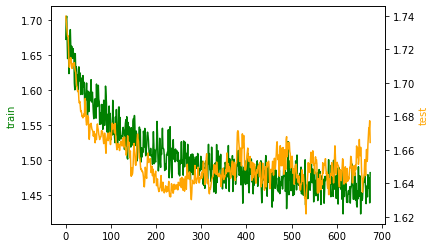

In [25]:
ax = plt.subplot((111))
plt.plot(train_loss[25:], 'green')
plt.ylabel('train', c='green')
ax2= ax.twinx()
plt.plot(test_loss[25:], 'orange')
plt.ylabel('test', c='orange')

Print model accuracies

In [26]:
#get the training and testing predictions from the model
ann.eval() #set to evaluation mode
vx_train, pred_train = torch.max(torch.nn.functional.softmax(ann.forward(X_train).detach(),1) , 1)
vy_train, iy_train = torch.max(y_train, 1)
vx_test, pred_test = torch.max(torch.nn.functional.softmax(ann.forward(X_test).detach(),1), 1)
vy_test, iy_test = torch.max(y_test, 1)

acc_train = accuracy_score(pred_train,iy_train)
acc_test = accuracy_score(pred_test,iy_test)

print("Training accuracy: {:.3f}".format( accuracy_score(pred_train,iy_train) ))
print("Testing accuracy: {:.3f}".format( accuracy_score(pred_test,iy_test)))

Training accuracy: 0.442
Testing accuracy: 0.411
